In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Understanding the data set
- Due to confidentiality issues many of the parameters cannot be names (V1-v28)
- Time denotes the time since the first transaction in the dataset
- Amount is the amount of the transaction
- Class is whether the transaction is fraud or not (0 = Not Fraud, 1 = Fraud)
## What percentage of the data is fraud?
- We would expect only a small amount of the transactions to be fraud. We should check this is true for the dataset.

In [3]:
x = df["Class"].value_counts()
print("None fraud = {nf}, fraud = {f}, Percentage fraud = {pf}%".format(nf=x[0], f=x[1], pf=(x[1]/x[0])*100))

None fraud = 284315, fraud = 492, Percentage fraud = 0.17304750013189596%


We see that fraudulent transactions make up less than 1% of events.

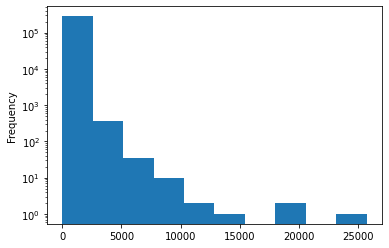

In [4]:
df["Amount"].plot.hist()
plt.yscale("log")
plt.show()

In [5]:
X = df.iloc[:, df.columns != "Class"]
y = df.iloc[:, df.columns == "Class"]
print(X.shape, y.shape)

(284807, 30) (284807, 1)


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scale_fit = StandardScaler().fit(X_train)
X_train = scale_fit.transform(X_train)
X_test = scale_fit.transform(X_test)

# Undersampling the data
- As we have a large imbalance between the number of ligitimate transactions and the number of fraudulent transactions it will be beneficial to undersample the data.
- This stops the model becoming to well trained on legitimate transactions and mitigates the amount of fraudulent events being missing
- We only undersample the training data as in a real world example we expect the unseen data to be predominantly legitimate transactions

In [10]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(y_resampled.shape)


(712, 1)


We can see we now have an equal number of legitimate transactions and fraudulent transactions in our training set

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score
clf = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000, random_state=10).fit(X_resampled, y_resampled.values.ravel())
y_pred = clf.predict(X_test)
recall_acc = recall_score (y_test,y_pred)
recall_acc 

0.9485294117647058